## Müşteri Segmentasyonu ve Hedefli Pazarlama İçin RFM Analizi

#### Amaç: Bu proje, bir şirketin müşteri tabanını segmentlere ayırarak hedefli pazarlama yapabilmesi ve müşteri satın alma alışkanlıklarını daha iyi anlayabilmesi için yapılmaktadır. RFM analizi (Recency, Frequency, Monetary), müşterileri en son ne zaman alışveriş yaptıklarına (recency),ne sıklıkla alışveriş yaptıklarına (frequency) ve ne kadar para harcadıklarına (monetary) göre değerlendirir.Bu proje, şirketin en değerli müşterilerini tanımlamasına ve onlara yönelik pazarlama stratejileri geliştirmesine yardımcı olacaktır.

In [3]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [5]:
file_path = 'PBL5recommendationdata.csv'
df = pd.read_csv(file_path, encoding='latin-1')

# Verinin ilk birkaç satırını göstererek yapısını anlayalım
df.head()

C:\Users\mucahit\AppData\Local\Temp\ipykernel_7576\1752869542.py:2: DtypeWarning: Columns (20,33,73,106,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin-1')


,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,...,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF61071,0.0,NaN
1,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF02132,NaN,NaN
2,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2 x Extra large,Nitrile,NaN,NaN,NaN,PF00342,0.0,NaN
3,4,James,Anderson,NaN,1386780263,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF04970,NaN,NaN
4,5,Abraham,Pollak,Company3,1386861599,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF03045,NaN,NaN


In [9]:
# Müşteriler için olan sütunları ayıralım
customer_columns = [col for col in df.columns if col.startswith('Customers')]
customers_df = df[customer_columns]

In [10]:
customers_df.head()

,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764306,0.0
1,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764354,0.0
2,3,John,Smith,Company1,1386089139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764354,0.0
3,4,James,Anderson,NaN,1386780263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437762646,0.0
4,5,Abraham,Pollak,Company3,1386861599,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1437764316,0.0


In [11]:
product_columns = [col for col in df.columns if col.startswith('Products')]
products_df = df[product_columns]

In [12]:
products_df.head()

,Products.id,Products.status,Products.product_type,Products.template,Products.vendor,Products.import_id,Products.name,Products.display_name,Products.menu_name,Products.list_price,...,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,2310.0,0.0,NaN,sub-product-detail.html,1.0,3.0,"Basic Steel Rollators,Green","Basic Lightweight Rollators For Adults, With S...",NaN,80.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF61071,0.0,NaN
1,177.0,1.0,NaN,sub-product-detail.html,1.0,3.0,Urinary Drain Bags,Urinary Drain Bags,NaN,14.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF02132,NaN,NaN
2,1.0,0.0,NaN,sub-product-detail.html,1.0,3.0,"SensiCare Nitrile Exam Gloves,Blue,XX-Large","SensiCare Nitrile Exam Gloves, Blue, XX-Large",NaN,96.29,...,NaN,NaN,2 x Extra large,Nitrile,NaN,NaN,NaN,PF00342,0.0,NaN
3,983.0,0.0,NaN,sub-product-detail.html,1.0,3.0,Basket for 2-Button Walkers,Basket for 2-Button Walkers,NaN,27.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF04970,NaN,NaN
4,991.0,1.0,NaN,sub-product-detail.html,1.0,3.0,TENS 3000 Analog Unit,TENS 3000 Analog Unit,NaN,50.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PF03045,NaN,NaN


In [13]:
order_columns = [col for col in df.columns if col.startswith('Orders')]
orders_df = df[order_columns]

In [14]:
orders_df.head()

,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,...,Orders.shipped_date,Orders.comments,Orders.notes,Orders.registry_id,Orders.gift_message,Orders.website,Orders.mailing,Orders.flags,Orders.partial_ship,Orders.customer_type
0,3758,797,Christy,Dill,Company0,3758,NaN,NaN,NaN,USD,...,1.426101e+09,NaN,Insured By Eye4Fraud,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,23,3,John,Smith,Company1,23,NaN,NaN,NaN,USD,...,1.386103e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,9531,3,John,Smith,Company1,9531,NaN,NaN,NaN,USD,...,NaN,test order,Test,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,29,4,James,Anderson,NaN,29,NaN,Ebay,NaN,USD,...,1.386800e+09,ebay order\rpaid by pay pal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,30,5,Abraham,Pollak,Company3,30,NaN,NaN,NaN,USD,...,1.386876e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [15]:
# 3. SQLite Veritabanına Veri Çerçevelerini Yerleştirme
# SQLite veritabanı bağlantısını oluşturalım
conn = sqlite3.connect('customer_segmentation.db')

In [16]:
# Veri çerçevelerini SQLite veritabanına yerleştirelim
customers_df.to_sql('customers', conn, if_exists='replace', index=False)
products_df.to_sql('products', conn, if_exists='replace', index=False)
orders_df.to_sql('orders', conn, if_exists='replace', index=False)

4194

In [17]:
## Veritabanındaki tabloları listeleyerek yerleştirmeyi doğrulayalım
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,customers
1,products
2,orders


In [18]:
# 4. Tabloları SQLite Veritabanından İçe Aktarma ve Birleştirme
# Tabloları veritabanından geri içe aktaralım
customers_df = pd.read_sql_query("SELECT * FROM customers", conn)
products_df = pd.read_sql_query("SELECT * FROM products", conn)
orders_df = pd.read_sql_query("SELECT * FROM orders", conn)

In [19]:
# Sütun isimlerini birleştirme için uygun hale getirelim
customers_df.rename(columns={'Customers.id': 'customer_id'}, inplace=True)
products_df.rename(columns={'Products.id': 'product_id'}, inplace=True)
orders_df.rename(columns={'Orders.customer_id': 'customer_id'}, inplace=True)

In [20]:
# Müşteriler ve Siparişleri Birleştirelim
merged_df = pd.merge(orders_df, customers_df, on='customer_id', how='left')

# Birleştirilen veri çerçevesinin ilk birkaç satırını gösterelim
merged_df.head()

,Orders.id,customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,...,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type
0,3758,797,Christy,Dill,Company0,3758,NaN,None,NaN,USD,...,NaN,NaN,None,NaN,NaN,None,None,None,1437764306,0.0
1,23,3,John,Smith,Company1,23,NaN,None,NaN,USD,...,NaN,NaN,None,NaN,NaN,None,None,None,1437764354,0.0
2,23,3,John,Smith,Company1,23,NaN,None,NaN,USD,...,NaN,NaN,None,NaN,NaN,None,None,None,1437764354,0.0
3,9531,3,John,Smith,Company1,9531,NaN,None,NaN,USD,...,NaN,NaN,None,NaN,NaN,None,None,None,1437764354,0.0
4,9531,3,John,Smith,Company1,9531,NaN,None,NaN,USD,...,NaN,NaN,None,NaN,NaN,None,None,None,1437764354,0.0


In [21]:
# 5. RFM (Recency, Frequency, Monetary) Analizi için Veri Hazırlığı
# İlgili sütunları çıkaralım
customer_orders_df = orders_df[['customer_id', 'Orders.subtotal', 'Orders.placed_date']]
customer_orders_df['Orders.placed_date'] = pd.to_datetime(customer_orders_df['Orders.placed_date'], unit='s')

C:\Users\mucahit\AppData\Local\Temp\ipykernel_7576\3193828469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_orders_df['Orders.placed_date'] = pd.to_datetime(customer_orders_df['Orders.placed_date'], unit='s')


In [22]:
# Müşteri ID'sine göre gruplama yaparak RFM metriklerini hesaplayalım
rfm_df = customer_orders_df.groupby('customer_id').agg({
    'Orders.placed_date': lambda x: (pd.Timestamp('now') - x.max()).days,
    'Orders.subtotal': ['count', 'sum']
}).reset_index()

In [23]:
# Çok seviyeli sütun isimlerini düzleştirelim
rfm_df.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# RFM veri çerçevesinin ilk birkaç satırını gösterelim
rfm_df.head()

,customer_id,Recency,Frequency,Monetary
0,3,3079,2,88.78
1,4,3806,1,19.56
2,5,3533,3,95.14
3,7,3790,1,39.19
4,8,3777,1,59.75


In [24]:
# 6. KMeans Kullanarak Müşteri Segmentasyonu
# KMeans ile en uygun küme sayısını belirleyelim
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(rfm_df[['Recency', 'Frequency', 'Monetary']])
    sse[k] = kmeans.inertia_

C:\Users\mucahit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mucahit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mucahit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mucahit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mucahit\anaconda3\Lib\site-packages\skl

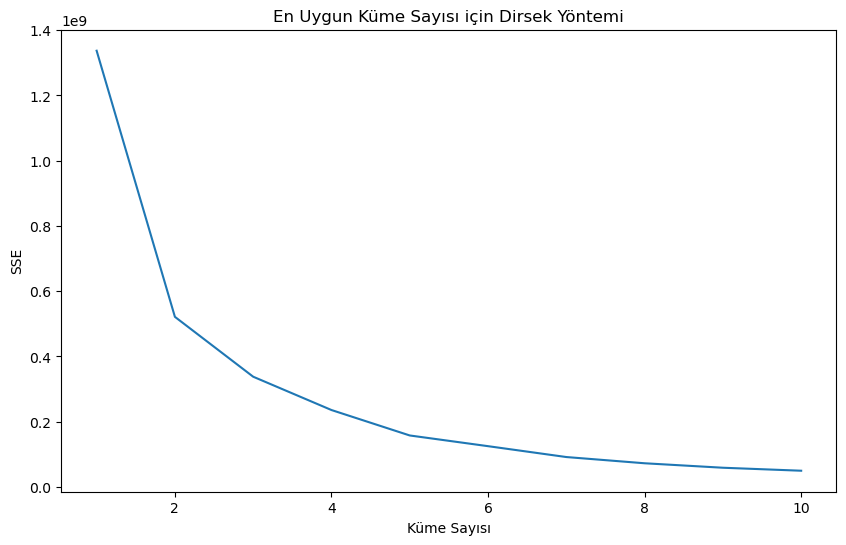

In [25]:
# Dirsek Yöntemini kullanarak grafiği çizelim
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Küme Sayısı")
plt.ylabel("SSE")
plt.title("En Uygun Küme Sayısı için Dirsek Yöntemi")
plt.show()

In [26]:
# 7. KMeans Kümeleme ve Küme Analizi
# Seçilen küme sayısıyla KMeans uygulayalım
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, max_iter=1000, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

C:\Users\mucahit\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
# Her küme için ortalama RFM değerlerini hesaplayalım
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'Customer Count'}).reset_index()

In [28]:
cluster_analysis

,Cluster,Recency,Frequency,Monetary,Customer Count
0,0,3151.403392,1.250748,118.933106,3007
1,1,3081.900000,7.925000,3213.972000,40
2,2,2989.857143,16.571429,9586.220000,7


In [29]:
# Son olarak, küme atamalarıyla birlikte RFM tablosunun ilk birkaç satırını gösterelim
rfm_df.head()

,customer_id,Recency,Frequency,Monetary,Cluster
0,3,3079,2,88.78,0
1,4,3806,1,19.56,0
2,5,3533,3,95.14,0
3,7,3790,1,39.19,0
4,8,3777,1,59.75,0
